# 三硬币模型

有ABC三枚硬币，单次投掷出现正面的概率分别为s、p、q。利用这三枚硬币进行如下实验：

1、第一次先投掷A，若出现正面则投掷B，否则投掷C

2、记录第二次投掷的硬币出现的结果，正面记作1，反面记作0

独立重复1和2十次，产生如下观测结果：

1 1 0 1 0 0 1 0 1 1

假设只能观测到掷硬币的最终结果，无法观测第一次投掷的是哪一枚硬币，求s、p、q，即三硬币模型的参数。

# coding

In [55]:
import numpy as np
np.set_printoptions(formatter={'all':lambda x: '%.4f' % x})

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

---

In [19]:
class SampleGenerator:
    
    def __init__(self, s, p, q, seed=100):
        r"""initialize the hyperparameters and setup random seed"""
        
        self.p = {"A":s, "B":p, "C":q}
        self.seed = seed
        
        np.random.seed(seed)
    
    def generate(self, N):
        r"""generate a length N sample"""
        self.count = {"A":N, "B":0, "C":0}
        self.data = {}
        
        self.data["A"] = np.random.binomial(n=1,p=self.p["A"],size=self.count["A"])
        
        self.count["B"]= np.count_nonzero(self.data["A"]==1)
        self.data["B"] = np.random.binomial(n=1,p=self.p["B"],size=self.count["B"])
        
        self.count["C"] = self.count["A"] - self.count["B"]
        self.data["C"] = np.random.binomial(n=1,p=self.p["C"],size=self.count["C"])
        
        self.output = np.empty(self.data["A"].shape, dtype=np.uint8)
        self.output[self.data["A"]==1][:] = self.data["B"][:]
        self.output[self.data["A"]==0][:] = self.data["C"][:]
        
        return self.output

In [123]:
SG = SampleGenerator(0.6, 0.6, 0.6)
sample = SG.generate(10)

In [124]:
SG.count, SG.p

({'A': 10, 'B': 7, 'C': 3}, {'A': 0.6, 'B': 0.6, 'C': 0.6})

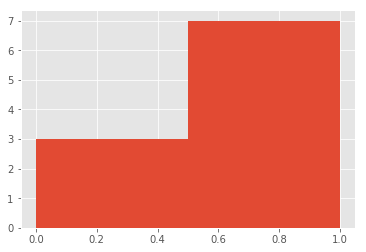

In [125]:
plt.hist(sample, bins=2);

求解这个问题分三步：
1. 初始化 : 选取模型参数的初值：$\theta^0 = (s^0, p^0, q^0)$循环如下两步迭代
2. E-step : 计算在当前迭代的模型参数下，观测数据$Y$来自硬币B的概率 
$$
\mu^{i+1} = \frac{s^i (p^{i})^{y_j} (1-p^i)^{1-y_j}}{s^i (p^{i})^{y_j} (1-p^i)^{1-y_j} + (1-s^i) (q^{i})^{y_j} (1-q^i)^{1-y_j}}
$$
3. M-step : 估算下一个迭代的新的模型估算值
$$
s^{i+1} = \frac{1}{N} \sum_{j=1}^{N} \mu_j^{i+1}
$$
$$
p^{i+1} = \frac{ \sum_{j=1}^{N} \mu_j^{i+1} y_j }{\sum_{j=1}^{N} \mu_j^{i+1}}
$$
$$
q^{i+1} = \frac{ \sum_{j=1}^{N} (1-\mu_j^{i+1}) y_j }{\sum_{j=1}^{N} (1-\mu_j^{i+1})}
$$

In [126]:
def EM_onestep(y, *args):
    
    #N = y.size
    s, p, q = args
    #print(s,p,q)
    #-- E-step
    #mu = np.empty(N, dtype=np.double)
    #for j in range(N):
    #    mu[j] = s * p**y[j]*(1-p)**(1-y[j]) / ( s * p**y[j]*(1-p)**(1-y[j]) + (1-s) * q**y[j]*(1-q)**(1-y[j]) )
    mu = s * p**y[:] * (1-p)**(1-y[:]) / ( s * p**y[:] * (1-p)**(1-y[:]) + (1-s) * q**y[:] * (1-q)**(1-y[:]) )
    #print(mu)
        
    #-- M-step
    s_new = mu.mean()
    p_new = mu.dot(y) / mu.sum()
    q_new = (1-mu).dot(y) / (1-mu).sum()
    
    return s_new, p_new, q_new

def EM_main(s, p, q, y, nLoop):
    
    s_, p_, q_ = s, p, q
    for i in range(1, nLoop):
        #print(f"i={i:3d}, s={thetas[i-1][0]:.4f}, p={thetas[i-1][1]:.4f}, q={thetas[i-1][2]:.4f}")
        print(s_, p_, q_)
        s_, p_, q_ = EM_onestep(y[:], s_, p_, q_)
        
    return thetas

In [127]:
thetas = EM_main(0.7, 0.5, 0.3, sample[:], nLoop=10)

0.7 0.5 0.3
0.744318181818 0.748091603053 0.56
0.744318181818 0.748091603053 0.56
0.744318181818 0.748091603053 0.56
0.744318181818 0.748091603053 0.56
0.744318181818 0.748091603053 0.56
0.744318181818 0.748091603053 0.56
0.744318181818 0.748091603053 0.56
0.744318181818 0.748091603053 0.56


In [128]:
EM_onestep(y[:], 0.1, 0.3, 0.6)

(0.10771113831089349, 0.2443181818181818, 0.53086419753086411)

In [129]:
EM_onestep(y[:], 0.10771113831089349, 0.2443181818181818, 0.53086419753086411)

(0.10771113831089349, 0.24431818181818185, 0.53086419753086411)

In [86]:
s, p, q = thetas[1,:]
y = sample
mu = s * p**y[:] * (1-p)**(1-y[:]) / ( s * p**y[:] * (1-p)**(1-y[:]) + (1-s) * q**y[:] * (1-q)**(1-y[:]) )
print(s, p, q, mu.mean())
print(mu)

0.0908207867897 0.379679144385 0.512019230769 0.0908207867897
[0.0690 0.1127 0.1127 0.0690 0.1127 0.1127 0.0690 0.0690 0.1127 0.0690]
